### Requirements

In [1]:
# %pip install -r requirements.txt

### Dependencies

In [2]:
import os
import random
import torch
import json
from pathlib import Path    # use this maybe for better cross-platform dependencies

random.seed(1997)
torch.manual_seed(1997)

### Global variables

### Generation of Original Data

In [3]:
GENERATE_ORIGINAL_DATA = False

In [4]:
N_TASKS = 10
N_SAMPLES = 12000   # NOTE: we should consider in that value also the number of samples that will be used for validation and for test

In [5]:
# Useful for iterative development
%load_ext autoreload
%autoreload 2

In [6]:
# path: where to save the generated data
# seed: random seed
# n_tasks: number of tasks to generate
# n_examples: number of examples to generate per task (400 tasks in total)
# diff_lb: lower bound of the sampled level of difficulty of the example
# diff_ub: upper bound of the sampled level of difficulty of the example
# specific_tasks: list of specific tasks (specified by their name without the file extension .json) to generate (if empty, generate n_tasks tasks)

if GENERATE_ORIGINAL_DATA:

    import generate_rearc_data

    # Parameters
    base_data_dir = './generated_data'
    seed = 1997
    n_tasks = N_TASKS    # max is 400; tasks are randomly selected unless specific_tasks is provided
    n_examples = N_SAMPLES  # NOTE: ideally we would generate 100k or 1M samples per task
    difficulties_lb = [0.0, 0.0, 0.7]
    difficulties_ub = [0.4, 0.7, 1.0]
    specific_tasks = []

    assert len(difficulties_lb) == len(difficulties_ub), "The number of lower bounds and upper bounds of the level of difficulty must be the same as they define a range."

    # Generate data
    generate_rearc_data.main(base_data_dir, seed, n_tasks, n_examples, difficulties_lb, difficulties_ub, specific_tasks)


### Pre-processing of Generated Data

In [7]:
# Create a json file that contains a dict that maps a task name to an id (positive integer)
# This is useful to later create a task embedding to be used by a model when making a prediction. Some simple ICL.
def create_task_name_to_id_dict(json_file_path):
    task_name_to_id_dict = {}
    for i, task_file in enumerate(os.listdir('./external/arc_original/training')):
        task_name_to_id_dict[task_file.split('.')[0]] = i

    with open(json_file_path, 'w') as f:
        json.dump(task_name_to_id_dict, f)

final_datasets_folder = "./final_datasets"
if not os.path.exists(final_datasets_folder):
    os.makedirs(final_datasets_folder)

create_task_name_to_id_dict(f"./{final_datasets_folder}/REARC_task_name_to_id.json")

In [8]:
# The data in the generated_data_<...> folder are JSON files.
# Each JSON file relates to one of the 400 tasks through an id such as "ff805c23".
# The JSON file contains a list of dictionaries with keys 'input' and 'output' where both 'input' and output are a list of list of symbols (integers 0-9).
# Hence, each dictionary in the list is a sample input-output pair for the task.

# The intended structure for storing the data should be:
# REARC/
#     final_datasets/
#         {study}/
#             exp_setting_{index}/
#                 experiment_{index}/
#                   train.json/ 
#                   val.json/
#                   test.json/

In [9]:
# NOTE: this is where we define the folders from which we create the datasets. 
# The folders samples_difficulty_<.> are created in final_datasets and contain 
# the samples for the different levels of difficulty to avoid overwriting or confusion with the generated data folders.

# N_TASKS is to set the number of tasks to the maximum number of different tasks found in ALL the samples_difficulty_<.> folders
# N_SAMPLES is to set the number of samples to the maximum number of samples found in ALL the samples_difficulty_<.> folders

# Select nb_tasks tasks randomly among the tasks for which samples were generated
def select_tasks_randomly(data_source_folder, nb_tasks):

    # Get the task names from the .txt file data_source_folder
    with open(data_source_folder, 'r') as f:
        tasks_selected = f.readlines()
    
    tasks_selected = [task.strip() for task in tasks_selected]
    print(f"Tasks available to be selected: {tasks_selected}")

    # Select random tasks
    selected_files = random.sample(tasks_selected, nb_tasks)

    selected_files = [task+".json" for task in selected_files]
    print(f"Selected task files: {selected_files}")

    return selected_files

def create_difficulty_samples_sets(tasks, nb_samples, difficulty_name):

    tasks_paths = [Path(f"./generated_data_{difficulty_name}") / "tasks" / task for task in tasks]
    structured_data_target_folder = f"samples_difficulty_{difficulty_name}"

    for task_path in tasks_paths:
        with open(task_path, 'r') as f:
            data = json.load(f)
        
        # Get the name of the task
        task_name = task_path.stem

        samples_difficulty_folder = Path("./final_datasets") / structured_data_target_folder
        samples_difficulty_folder.mkdir(parents=True, exist_ok=True)
        
        sampled_data = random.sample(data, nb_samples)

        # Add the task name and difficulty information to each sample
        for sample in sampled_data:
            sample["task"] = task_name
            sample["sample_difficulty"] = difficulty_name
        
        with open(samples_difficulty_folder / f"{task_name}.json", 'w') as f:
            json.dump(sampled_data, f, indent=4)
    
    print(f"Sets of tasks with samples successfully created in {structured_data_target_folder}")

data_source_folder="./tasks_generated.txt"   # NOTE: this should be the path to a folder whose tasks are all present in all the other folders of different tasks levels of difficulty
tasks = select_tasks_randomly(data_source_folder, N_TASKS)

# Use for Sample-Efficiency study
difficulty_name = "lb0_ub04" 
create_difficulty_samples_sets(
    tasks=tasks,
    nb_samples=N_SAMPLES,
    difficulty_name=difficulty_name
)

# Use for Systematic Generalization study
difficulty_name = "lb0_ub07"
create_difficulty_samples_sets(
    tasks=tasks,
    nb_samples=N_SAMPLES,
    difficulty_name=difficulty_name,
)

difficulty_name = "lb07_ub1"
create_difficulty_samples_sets(
    tasks=tasks,
    nb_samples=N_SAMPLES,
    difficulty_name=difficulty_name,
)


Tasks available to be selected: ['fafffa47', 'cbded52d', 'd4a91cb9', 'dae9d2b5', '90f3ed37', '2281f1f4', '3618c87e', 'd037b0a7', '6d75e8bb', 'db93a21d']
Selected task files: ['dae9d2b5.json', 'cbded52d.json', 'db93a21d.json', '6d75e8bb.json', '2281f1f4.json', '3618c87e.json', 'd037b0a7.json', '90f3ed37.json', 'd4a91cb9.json', 'fafffa47.json']
Sets of tasks with samples successfully created in samples_difficulty_lb0_ub04
Sets of tasks with samples successfully created in samples_difficulty_lb0_ub07
Sets of tasks with samples successfully created in samples_difficulty_lb07_ub1


In [10]:
import os
from collections import Counter

def create_list_of_chosen_tasks(folders, destination):
    
    os.makedirs(destination, exist_ok=True)
    
    # Get list of files in each folder
    file_occurrences = Counter()
    folder_files = {}
    
    for folder in folders:
        files = set(os.listdir(folder))
        folder_files[folder] = files
        file_occurrences.update(files)
    
    # Find files that appear in all folders
    task_files = {file for file, count in file_occurrences.items() if count == len(folders)}
    
    all_task_names_chosen = []
    for file in task_files:
        for folder in folders:
            source_path = os.path.join(folder, file)
            if os.path.isfile(source_path):
                all_task_names_chosen.append(file.replace('.json', ''))
                break  # we copy only once from the first found folder
    
    # Save in a text file the task names chosen for the experiments
    with open(os.path.join(destination, 'chosen_tasks.txt'), 'w') as f:
        for task in all_task_names_chosen:
            f.write(task + '\n')

all_sample_difficulties_folders = ['./final_datasets/samples_difficulty_lb0_ub04', './final_datasets/samples_difficulty_lb0_ub07', './final_datasets/samples_difficulty_lb07_ub1']

# NOTE: not used for now. It is useful in case the tasks consiered to create the experiments would be different than the ones in the file "tasks_generated.txt"
# create_list_of_chosen_tasks(all_sample_difficulties_folders, './final_datasets')

### General Functions and Classes

In [11]:
def get_tasks_names_from_folder(tasks_folder):
    return [task.stem for task in Path(tasks_folder).glob("*.json")]

In [12]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import json

In [13]:
# Subclass PyTorch Dataset so that it can then be loaded with a DataLoader
class CustomREARCDataset(Dataset):
    def __init__(self, json_data_split_path, use_padding=False):
        super().__init__()
        
        with open(json_data_split_path, 'r') as f:
            self.samples = json.load(f)
        
        self.n_samples = len(self.samples)

        self.use_padding = use_padding
        self.max_grid_size = (30, 30)  # maximum grid size

    def pad_sample(self, sample):
        sample_tensor = torch.tensor(sample, dtype=torch.long)

        padded_sample_tensor = F.pad(
            sample_tensor, 
            (0, self.max_grid_size[1] - sample_tensor.shape[1],  # pad width
             0, self.max_grid_size[0] - sample_tensor.shape[0]), # pad height
            value=10  # padding value
        )
        return padded_sample_tensor
    
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx):
        
        sample = self.samples[idx]
        
        input_sample = torch.tensor(sample['input'], dtype=torch.long)
        output_sample = torch.tensor(sample['output'], dtype=torch.long)

        if self.use_padding:
            input_sample = self.pad_sample(input_sample)
            output_sample = self.pad_sample(output_sample)
        
        return input_sample, output_sample  # NOTE: would it be better to return a concatenated tensor instead of a tuple?

In [14]:
# NOTE:
# The DataLoader batches multiple samples together, but it requires all tensors in a batch to have the same shape to stack them into a single tensor.
# If our dataset has samples of different sizes (e.g., one sample is 16x14 and another is 16x13), torch.stack() will fail within the dataloader.
# Therefore, we need to use padding. Padding can be either done dynamically for the Dataloader object or pre-determined for the Dataset object.

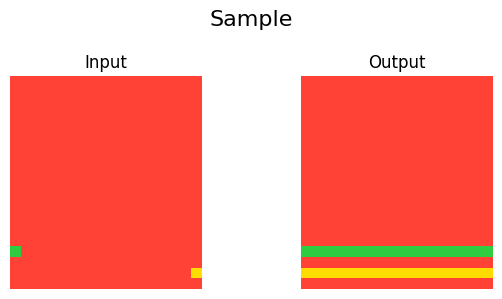

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize

def display_grid_image(sample, title=None):

    if isinstance(sample, dict):
        input_data = sample['input']
        output_data = sample['output']
    elif isinstance(sample, tuple):
        input_data, output_data = sample

    # Use the same color map as REARC
    cmap = ListedColormap([
        '#000', '#0074D9', '#FF4136', '#2ECC40', '#FFDC00',
        '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'
    ])
    norm = Normalize(vmin=0, vmax=9)
    args = {'cmap': cmap, 'norm': norm}

    # Define figure size
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))  # 1 row, 2 columns

    # Plot input grid image
    axes[0].imshow(input_data, **args)
    axes[0].set_title("Input")
    axes[0].axis('off')

    # Plot output grid image
    axes[1].imshow(output_data, **args)
    axes[1].set_title("Output")
    axes[1].axis('off')

    if title:
        fig.suptitle(title, fontsize=16)

    plt.tight_layout()
    plt.show()


# Test viewing a generated data sample
task_file = None

if task_file is not None:
    dataset = CustomREARCDataset(task_file, use_padding=False)
    sample_tuple = dataset[0]
    display_grid_image(sample_tuple, title="Sample")

C:\Users\klimm\AppData\Local\Temp\ipykernel_47260\912861309.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_tensor = torch.tensor(sample, dtype=torch.long)


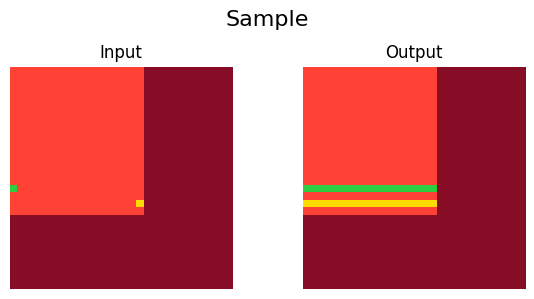

In [ ]:
if task_file is not None:
    dataset = CustomREARCDataset(task_file, use_padding=True)
    sample_tuple = dataset[0]
    display_grid_image(sample_tuple, title="Sample")

In [17]:
def collate_fn(batch):
    inputs = [torch.tensor(sample[0], dtype=torch.long) for sample in batch]
    outputs = [torch.tensor(sample[1], dtype=torch.long) for sample in batch]

    max_grid_size = (30, 30)

    if not (inputs[0].shape[0] == max_grid_size[0] and inputs[0].shape[1] == max_grid_size[1]): # check if need to pad

        def pad_tensor(tensor, max_h, max_w):
            return F.pad(tensor, (0, max_w - tensor.shape[1], 0, max_h - tensor.shape[0]), value=0)

        inputs = torch.stack([pad_tensor(t, max_grid_size[0], max_grid_size[1]) for t in inputs])
        outputs = torch.stack([pad_tensor(t, max_grid_size[0], max_grid_size[1]) for t in outputs])

    return inputs, outputs

# Sanity check
def check_REARC_dataloader(dataset_split_path, use_dataloader_padding=False):
    dataset = CustomREARCDataset(dataset_split_path, use_padding=False)

    if use_dataloader_padding:
        dataloader = DataLoader(dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)
    else:
        dataloader = DataLoader(dataset, batch_size=4, shuffle=False)

    # sample_from_dataset = dataset[0]
    # print("Sample from dataset: ", sample_from_dataset)

    # sample_from_dataloader = next(iter(dataloader))
    # print("Sample from dataloader: ", sample_from_dataloader)

    for input_batch, output_batch in dataloader:
        print("Input batch shape: ", input_batch.shape)
        print("Output batch shape: ", output_batch.shape)
        sample = input_batch[0], output_batch[0]
        break

    if sample is None:
        raise ValueError("No sample found in the dataloader")

    display_grid_image(sample, title="Sample from dataloader")

    return dataloader


In [18]:
def save_new_dataset_split(experiment_folder_path, split, data_json):
    
    # Save the selected samples to a JSON file with the name of the split
    json_dataset_split_path = f"{experiment_folder_path}/{split}.json"
    os.makedirs(os.path.dirname(json_dataset_split_path), exist_ok=True)
   
    with open(json_dataset_split_path, "w") as f:
        json.dump(data_json, f, indent=4)

    print(f"New dataset created at: {json_dataset_split_path}")

In [ ]:
def create_datasets_sample_efficiency(study_folder_path, experiment_setting):
    study = "sample-efficiency"

    assert len(experiment_setting['splits']) == 3, "The number of splits must be 3 (for train, val, test)"

    exp_setting_folder_path = f"{study_folder_path}/exp_setting_{experiment_setting['index']}"
    print("Created path experiment setting: ", exp_setting_folder_path)

    if experiment_setting['index'] == "1":
        experiment_index = 0

        for task_name in experiment_setting['tasks']:
            for train_size, val_size, test_size in zip(experiment_setting['train_sizes'], experiment_setting['val_sizes'], experiment_setting['test_sizes']):
                experiment_index += 1

                experiment_folder_path = f"{exp_setting_folder_path}/experiment_{experiment_index}"
                os.makedirs(experiment_folder_path, exist_ok=True)
                print("Created path experiment: ", experiment_folder_path)

                # Select disjointly train_size, val_size, test_size samples for each task from the samples difficulty folder with tasks json files
                task = f"./final_datasets/samples_difficulty_{experiment_setting['diff_level']}/{task_name}.json"
                with open(task, 'r') as f:
                    data = json.load(f)

                random.shuffle(data)

                print(f"Task {task_name} has {len(data)} samples")
                
                split = "train"
                train_data = data[:train_size]
                save_new_dataset_split(experiment_folder_path, split, train_data)
    
                split = "val"
                val_data = data[train_size:train_size+val_size]
                save_new_dataset_split(experiment_folder_path, split, val_data)

                split = "test"
                test_data = data[train_size+val_size:train_size+val_size+test_size]
                save_new_dataset_split(experiment_folder_path, split, test_data)

                # Save metadata (all the variables that take a different value as the variable experiment_index changes) about the dataset
                experiment_metadata = {
                    'study': study,
                    'experiment_setting': experiment_setting,
                    'experiment_index': experiment_index,
                    'task': task_name,
                    'train_size': train_size,
                    'val_size': val_size,
                    'test_size': test_size,
                }
                
                metadata_dataset_path = f"{experiment_folder_path}/dataset_metadata.json"
                with open(metadata_dataset_path, "w") as f:
                    json.dump(experiment_metadata, f, indent=4)
                
                print(f"Metadata about the created experiment dataset saved at: {metadata_dataset_path}")



In [ ]:
def create_datasets_systematic_generalization(study_folder_path, experiment_setting):
    study = "sys-gen"

    assert len(experiment_setting['splits']) == 4, "The number of splits must be 4 (for train, val, test, test_gen)"

    exp_setting_folder_path = f"{study_folder_path}/exp_setting_{experiment_setting['index']}"
    print("Created path experiment setting: ", exp_setting_folder_path)

    if experiment_setting['index'] == "1":
        experiment_index = 0

        for task_name in experiment_setting['tasks']:
            for train_size, val_size, test_size, test_gen_size in zip(experiment_setting['train_sizes'], experiment_setting['val_sizes'], experiment_setting['test_sizes'], experiment_setting['test_gen_sizes']):
                experiment_index += 1

                experiment_folder_path = f"{exp_setting_folder_path}/experiment_{experiment_index}"
                os.makedirs(experiment_folder_path, exist_ok=True)
                print("Created path experiment: ", experiment_folder_path)

                # Select disjointly train_size and test_size samples for each task from the easier samples difficulty folder with tasks json files
                task = f"./final_datasets/samples_difficulty_{experiment_setting['diff_level_easier']}/{task_name}.json"
                with open(task, 'r') as f:
                    data = json.load(f)

                random.shuffle(data)

                print(f"Task {task_name} has {len(data)} train samples")

                # Select disjointly val_size and test_gen_size samples for each task from the harder samples difficulty folder with tasks json files
                task = f"./final_datasets/samples_difficulty_{experiment_setting['diff_level_harder']}/{task_name}.json"
                with open(task, 'r') as f:
                    gen_data = json.load(f)
                
                random.shuffle(gen_data)

                print(f"Task {task_name} has {len(gen_data)} OOD generalization samples")
                # print("Generalization Data in the task are: ", data)

                split = "train"
                train_data = data[:train_size]
                save_new_dataset_split(experiment_folder_path, split, train_data)
    
                # Use it to validate the trained model on OOD samples
                split = "val"
                val_data = gen_data[:val_size]
                save_new_dataset_split(experiment_folder_path, split, val_data)

                # Use it to test the trained model on in-domain samples, for sanity check and in-domain generalization
                split = "test"
                test_data = data[train_size:train_size+test_size]
                save_new_dataset_split(experiment_folder_path, split, test_data)

                # Use it to test the trained model on OOD samples, for systematic generalization
                split = "test_gen"
                test_gen_data = gen_data[val_size:val_size+test_gen_size]
                save_new_dataset_split(experiment_folder_path, split, test_gen_data)

                # Save metadata (all the variables that take a different value as the variable experiment_index changes) about the dataset
                experiment_metadata = {
                    'study': study,
                    'experiment_setting': experiment_setting,
                    'experiment_index': experiment_index,
                    'task': task_name,
                    'train_size': train_size,
                    'val_size': val_size,
                    'test_size': test_size,
                }
                
                metadata_dataset_path = f"{experiment_folder_path}/dataset_metadata.json"
                with open(metadata_dataset_path, "w") as f:
                    json.dump(experiment_metadata, f, indent=4)
                
                print(f"Metadata about the created experiment dataset saved at: {metadata_dataset_path}")


In [21]:
def create_dataset(study_folder_path, study, experiment_setting):

    if study == "sample-efficiency":
        create_datasets_sample_efficiency(study_folder_path, experiment_setting)

    elif study == "sys-gen":
        create_datasets_systematic_generalization(study_folder_path, experiment_setting)

    else:
        raise ValueError("Study must be one of 'sample-efficiency', 'compositionality', or 'sys-gen'")


### Main

In [22]:
# Define the folders that will be used for the datasets
# data_environment = "REARC"
data_source_root = "./generated_data"  # Root directory for datasets
final_datasets_root = "./final_datasets"  # Root directory for datasets

# Define and create the directories for each dataset setting
sample_efficiency_dir = f"{final_datasets_root}/sample-efficiency"
sys_gen_dir = f"{final_datasets_root}/sys-gen"

os.makedirs(sample_efficiency_dir, exist_ok=True)
os.makedirs(sys_gen_dir, exist_ok=True)

print(f"Data source root: {data_source_root}")
print(f"Final datasets root: {final_datasets_root}")

print(f"Sample efficiency folder: {sample_efficiency_dir}")
print(f"Systematic Generalization folder: {sys_gen_dir}")


Data source root: ./generated_data
Final datasets root: ./final_datasets
Sample efficiency folder: ./final_datasets/sample-efficiency
Systematic Generalization folder: ./final_datasets/sys-gen


In [23]:
def observe_input_output_images(dataloader, batch_id=0, n_samples=4, split="test"):

    # Get the first batch of the dataloader
    batch = next(iter(dataloader))

    # Get the input and output images
    inputs = batch[0]
    outputs = batch[1]

    # Get the number of samples to observe
    n_samples = min(n_samples, len(inputs))

    print(f"Observing {n_samples} samples from the batch {batch_id} at test time. See /figs folder.")

    # Replace the symbols for pad tokens with the background color
    # TODO: How to handle the pad token properly? For example if its decided value is not 10.0 anymore as it was changed in the other parts of the code?
    pad_token = 10
    inputs[inputs == pad_token] = 0
    outputs[outputs == pad_token] = 0

    # Use the same color map as REARC
    cmap = ListedColormap([
        '#000', '#0074D9', '#FF4136', '#2ECC40', '#FFDC00',
        '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'
    ])
    norm = Normalize(vmin=0, vmax=9)    # there are 10 possible symbols (0-9) to predict in the grid image
    args = {'cmap': cmap, 'norm': norm}

    # Create a figure to plot the samples
    fig, axs = plt.subplots(2, n_samples, figsize=(n_samples*5, 12))

    print(f"inputs shape: {inputs.shape}, outputs shape: {outputs.shape}")
    print(f"inputs dtype: {inputs.dtype}, outputs dtype: {outputs.dtype}")
    print(f"inputs min: {inputs.min()}, outputs min: {outputs.min()}")
    print(f"inputs max: {inputs.max()}, outputs max: {outputs.max()}")
    print(f"inputs: {inputs}")
    print(f"outputs: {outputs}")

    for i in range(n_samples):
        input_img = inputs[i, :, :].numpy()
        target = outputs[i, :, :].cpu().numpy()

        # Plot the input image
        axs[0, i].imshow(input_img, **args)
        axs[0, i].set_title(f"Input (sample {i} of batch)")
        axs[0, i].axis('off')

        # Plot the target output
        axs[1, i].imshow(target, **args)
        axs[1, i].set_title(f"Output (sample {i} of batch)")
        axs[1, i].axis('off')

        fig.suptitle(f"{split} batch {batch_id}", fontsize=16)

    plt.tight_layout()
    plt.show()

    # Save the figure
    # fig.savefig(f"./figs/ipynb_{split}_image_input_output_batch{batch_id}.png")

    plt.close()

## Studies

### Sample-Efficiency

In [24]:
random.seed(1997)
torch.manual_seed(1997)

In [25]:
study = "sample-efficiency"

In [26]:
# ** Experiment setting 1: Best Performance for Varying Number N of Samples **

exp_setting_desc = """Experiment setting 1: Best Performance for Varying Number N of Samples"""

# We consider 10 tasks sampled randomly from the 400 tasks
# We consider samples closer to representing an "elementary" task by choosing the level of difficulty in [0, 0.4]
# We create train datasets of size N_train = 100, 1000, 10000, 100000
# We create val datasets of size N_val = 1000
# We create test datasets of size N_test = 1000

splits = ['train', 'val', 'test']
experiment_setting_base = {'index': "1", 'splits': splits}

nb_tasks = 10
diff_level = "lb0_ub04"

chosen_tasks_folder = './tasks_generated.txt'
with open(chosen_tasks_folder, 'r') as f:
    tasks = f.read().splitlines()

train_sizes = [100, 1000, 10000]
val_sizes = [1000] * len(train_sizes)
test_sizes = [1000] * len(train_sizes)

experiment_setting = {**experiment_setting_base, 
                      'tasks': tasks,
                      'diff_level': diff_level,
                      'train_sizes': train_sizes, 
                      'val_sizes': val_sizes, 
                      'test_sizes': test_sizes,
                      'desc': exp_setting_desc
                      }

create_dataset(sample_efficiency_dir, study, experiment_setting)


Created path experiment setting:  ./final_datasets/sample-efficiency/exp_setting_1
Created path experiment:  ./final_datasets/sample-efficiency/exp_setting_1/experiment_1
<class 'list'>
Task fafffa47 has 12000 samples
New dataset created at: ./final_datasets/sample-efficiency/exp_setting_1/experiment_1/train.json
New dataset created at: ./final_datasets/sample-efficiency/exp_setting_1/experiment_1/val.json
New dataset created at: ./final_datasets/sample-efficiency/exp_setting_1/experiment_1/test.json
Metadata about the created experiment dataset saved at: ./final_datasets/sample-efficiency/exp_setting_1/experiment_1/dataset_metadata.json
Created path experiment:  ./final_datasets/sample-efficiency/exp_setting_1/experiment_2
<class 'list'>
Task fafffa47 has 12000 samples
New dataset created at: ./final_datasets/sample-efficiency/exp_setting_1/experiment_2/train.json
New dataset created at: ./final_datasets/sample-efficiency/exp_setting_1/experiment_2/val.json
New dataset created at: ./f

Input batch shape:  torch.Size([4, 30, 30])
Output batch shape:  torch.Size([4, 30, 30])


C:\Users\klimm\AppData\Local\Temp\ipykernel_47260\2204237555.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(sample[0], dtype=torch.long) for sample in batch]
C:\Users\klimm\AppData\Local\Temp\ipykernel_47260\2204237555.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = [torch.tensor(sample[1], dtype=torch.long) for sample in batch]


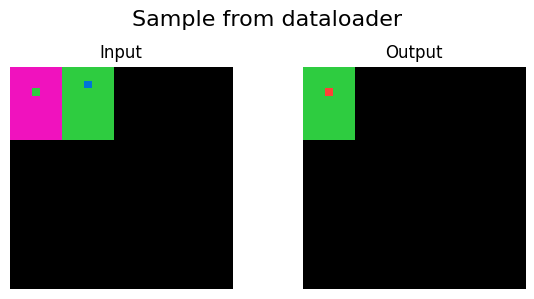

In [27]:
dataset_train_path = "./final_datasets/sample-efficiency/exp_setting_1/experiment_1/test.json"
dataloader = check_REARC_dataloader(dataset_train_path, use_dataloader_padding=True)

C:\Users\klimm\AppData\Local\Temp\ipykernel_47260\2204237555.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(sample[0], dtype=torch.long) for sample in batch]
C:\Users\klimm\AppData\Local\Temp\ipykernel_47260\2204237555.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = [torch.tensor(sample[1], dtype=torch.long) for sample in batch]


Observing 4 samples from the batch 0 at test time. See /figs folder.
inputs shape: torch.Size([4, 30, 30]), outputs shape: torch.Size([4, 30, 30])
inputs dtype: torch.int64, outputs dtype: torch.int64
inputs min: 0, outputs min: 0
inputs max: 9, outputs max: 4
inputs: tensor([[[6, 6, 6,  ..., 0, 0, 0],
         [6, 6, 6,  ..., 0, 0, 0],
         [6, 6, 6,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[3, 3, 3,  ..., 0, 0, 0],
         [5, 3, 3,  ..., 0, 0, 0],
         [3, 3, 3,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[4, 4, 4,  ..., 0, 0, 0],
         [4, 4, 4,  ..., 0, 0, 0],
         [4, 4, 4,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[4, 4, 4,  ..., 0, 0, 0],
         [4, 4, 4,

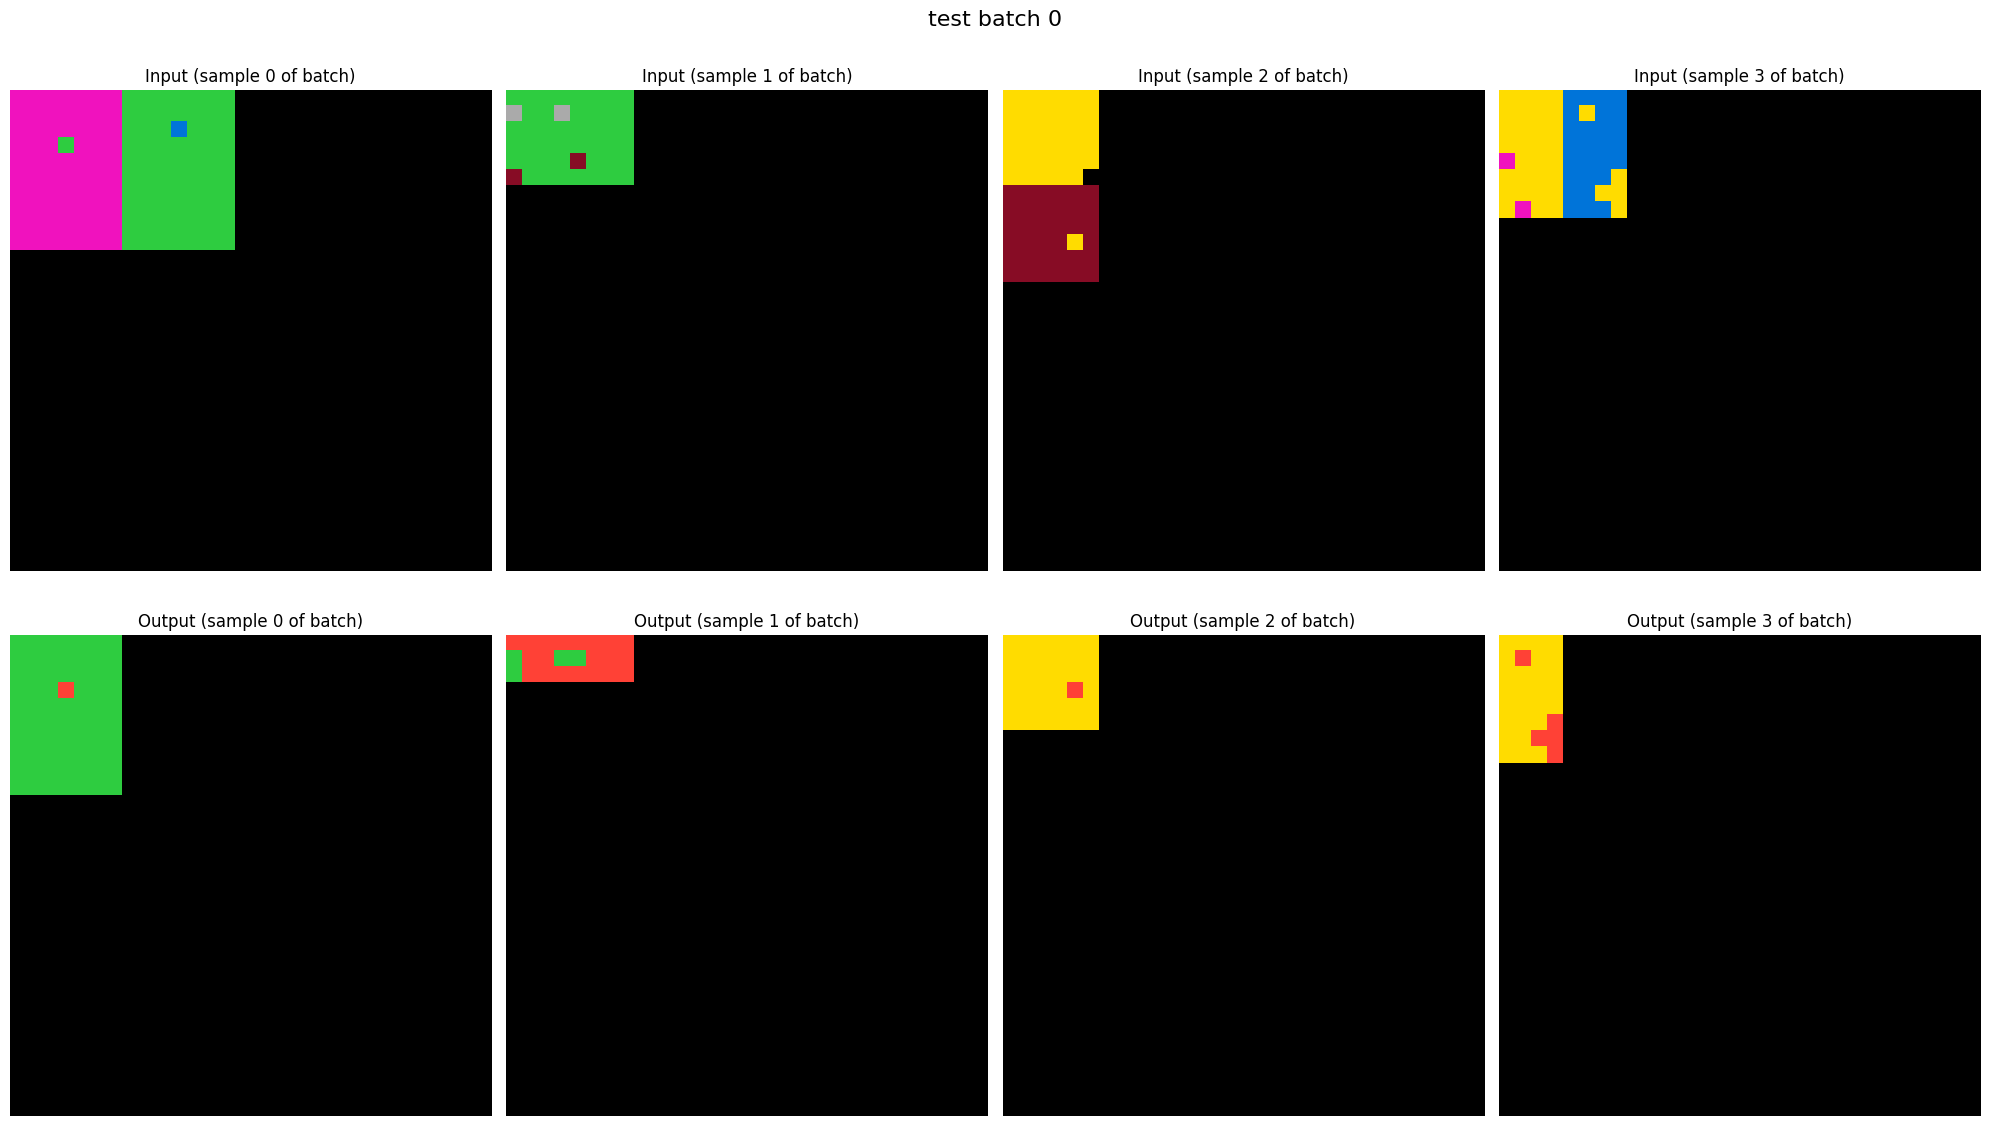

In [28]:
observe_input_output_images(dataloader, batch_id=0, n_samples=4, split="test")

Input batch shape:  torch.Size([4, 30, 30])
Output batch shape:  torch.Size([4, 30, 30])


C:\Users\klimm\AppData\Local\Temp\ipykernel_47260\2204237555.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(sample[0], dtype=torch.long) for sample in batch]
C:\Users\klimm\AppData\Local\Temp\ipykernel_47260\2204237555.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = [torch.tensor(sample[1], dtype=torch.long) for sample in batch]


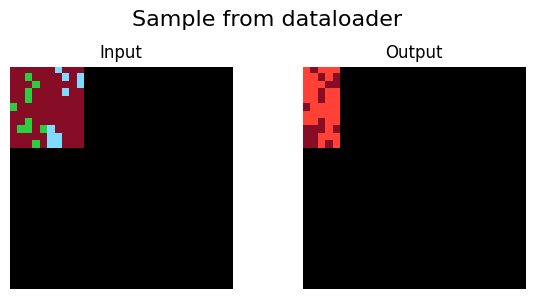

In [29]:
dataset_train_path = "./final_datasets/sample-efficiency/exp_setting_1/experiment_2/train.json"
check_REARC_dataloader(dataset_train_path, use_dataloader_padding=True)

Input batch shape:  torch.Size([4, 30, 30])
Output batch shape:  torch.Size([4, 30, 30])


C:\Users\klimm\AppData\Local\Temp\ipykernel_47260\2204237555.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(sample[0], dtype=torch.long) for sample in batch]
C:\Users\klimm\AppData\Local\Temp\ipykernel_47260\2204237555.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = [torch.tensor(sample[1], dtype=torch.long) for sample in batch]


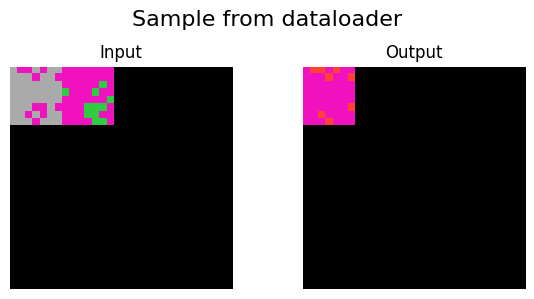

In [30]:
dataset_test_path = "./final_datasets/sample-efficiency/exp_setting_1/experiment_2/test.json"
check_REARC_dataloader(dataset_test_path, use_dataloader_padding=True)

### Systematic Generalization

In [31]:
random.seed(1997)
torch.manual_seed(1997)

In [32]:
study = "sys-gen"

In [33]:
# ** Experiment setting 1: Various Parameters Cardinality Difficulty **

exp_setting_desc = """Experiment setting 1: Various Parameters Cardinality Difficulty"""

# We consider 10 tasks sampled randomly from the 400 tasks
# We consider "easier" samples with the level of difficulty in [0, 0.7] and "harder" samples with the level of difficulty in [0.7, 1]
# We create train datasets of size N_train = 100000
# We create val datasets of size N_val = 1000
# We create test datasets of size N_test = 1000
# We create test_gen datasets of size N_test_gen = 1000

splits = ['train', 'val', 'test', 'test_gen']
experiment_setting_base = {'index': "1", 'splits': splits}

nb_tasks = 10

diff_level_easier = "lb0_ub07"
diff_level_harder = "lb07_ub1"

# chosen_tasks_folder = './final_datasets/chosen_tasks.txt'
chosen_tasks_folder = './tasks_generated.txt'
with open(chosen_tasks_folder, 'r') as f:
    tasks = f.read().splitlines()

train_sizes = [10000]
val_sizes = [1000] * len(train_sizes)
test_sizes = [1000] * len(train_sizes)
test_gen_sizes = [1000] * len(train_sizes)

experiment_setting = {**experiment_setting_base, 
                      'tasks': tasks, 
                      'diff_level_easier': diff_level_easier,
                      'diff_level_harder': diff_level_harder,
                      'train_sizes': train_sizes, 
                      'val_sizes': val_sizes, 
                      'test_sizes': test_sizes,
                      'test_gen_sizes': test_gen_sizes,
                      'desc': exp_setting_desc
                      }

create_dataset(sys_gen_dir, study, experiment_setting)


Created path experiment setting:  ./final_datasets/sys-gen/exp_setting_1
Created path experiment:  ./final_datasets/sys-gen/exp_setting_1/experiment_1
Task fafffa47 has 12000 train samples
Task fafffa47 has 12000 OOD generalization samples
New dataset created at: ./final_datasets/sys-gen/exp_setting_1/experiment_1/train.json
New dataset created at: ./final_datasets/sys-gen/exp_setting_1/experiment_1/val.json
New dataset created at: ./final_datasets/sys-gen/exp_setting_1/experiment_1/test.json
New dataset created at: ./final_datasets/sys-gen/exp_setting_1/experiment_1/test_gen.json
Metadata about the created experiment dataset saved at: ./final_datasets/sys-gen/exp_setting_1/experiment_1/dataset_metadata.json
Created path experiment:  ./final_datasets/sys-gen/exp_setting_1/experiment_2
Task cbded52d has 12000 train samples
Task cbded52d has 12000 OOD generalization samples
New dataset created at: ./final_datasets/sys-gen/exp_setting_1/experiment_2/train.json
New dataset created at: ./fi

Input batch shape:  torch.Size([4, 30, 30])
Output batch shape:  torch.Size([4, 30, 30])


C:\Users\klimm\AppData\Local\Temp\ipykernel_47260\2204237555.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(sample[0], dtype=torch.long) for sample in batch]
C:\Users\klimm\AppData\Local\Temp\ipykernel_47260\2204237555.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = [torch.tensor(sample[1], dtype=torch.long) for sample in batch]


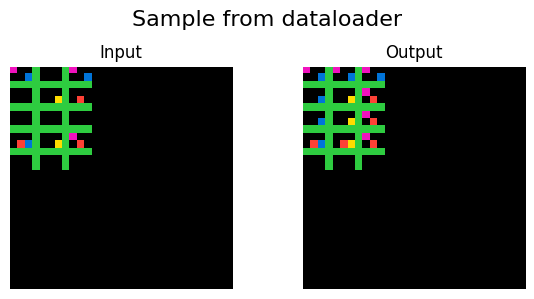

In [34]:
dataset_train_path = "./final_datasets/sys-gen/exp_setting_1/experiment_2/train.json"
check_REARC_dataloader(dataset_train_path, use_dataloader_padding=True)

Input batch shape:  torch.Size([4, 30, 30])
Output batch shape:  torch.Size([4, 30, 30])


C:\Users\klimm\AppData\Local\Temp\ipykernel_47260\2204237555.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(sample[0], dtype=torch.long) for sample in batch]
C:\Users\klimm\AppData\Local\Temp\ipykernel_47260\2204237555.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = [torch.tensor(sample[1], dtype=torch.long) for sample in batch]


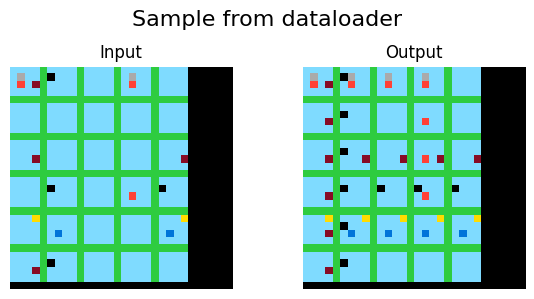

In [35]:
dataset_test_path = "./final_datasets/sys-gen/exp_setting_1/experiment_2/val.json"
check_REARC_dataloader(dataset_test_path, use_dataloader_padding=True)

Input batch shape:  torch.Size([4, 30, 30])
Output batch shape:  torch.Size([4, 30, 30])


C:\Users\klimm\AppData\Local\Temp\ipykernel_47260\2204237555.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(sample[0], dtype=torch.long) for sample in batch]
C:\Users\klimm\AppData\Local\Temp\ipykernel_47260\2204237555.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = [torch.tensor(sample[1], dtype=torch.long) for sample in batch]


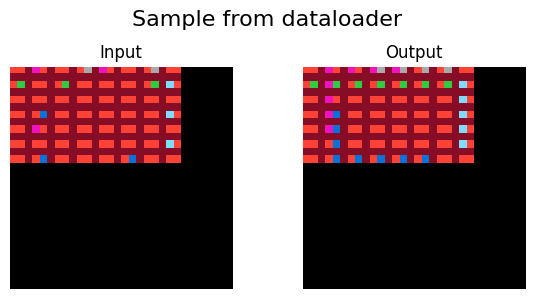

In [36]:
dataset_test_path = "./final_datasets/sys-gen/exp_setting_1/experiment_2/test.json"
check_REARC_dataloader(dataset_test_path, use_dataloader_padding=True)

Input batch shape:  torch.Size([4, 30, 30])
Output batch shape:  torch.Size([4, 30, 30])


C:\Users\klimm\AppData\Local\Temp\ipykernel_47260\2204237555.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(sample[0], dtype=torch.long) for sample in batch]
C:\Users\klimm\AppData\Local\Temp\ipykernel_47260\2204237555.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = [torch.tensor(sample[1], dtype=torch.long) for sample in batch]


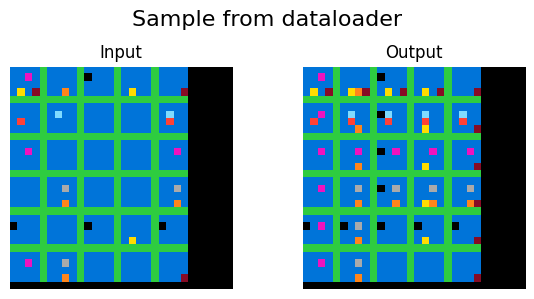

In [37]:
dataset_test_gen_path = "./final_datasets/sys-gen/exp_setting_1/experiment_2/test_gen.json"
check_REARC_dataloader(dataset_test_gen_path, use_dataloader_padding=True)